Kilian Cannet - Noe Boonstra

# Importation

In [34]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
print("Done")

Done


# Chargement données

In [42]:
#https://www.kaggle.com/priteshshrivastava/sample-github-code
data = pd.read_csv("sample_code.csv", lineterminator='\n',names=['content','lang'])
data.head(10)

,content,lang
0,content,type
1,// Utility.cs\n//\n\nusing System;\nusing Syst...,cs
2,\n{$options.identity.sitename} - Your Accounts...,txt
3,"{\n ""name"": ""opulence/sessions"",\n ""descript...",json
4,package io.mycat.backend.postgresql.packet;\r\...,java
5,TAPi18n._afterUILanguageChange = function() {\...,js
6,"filter:\n paths: [""src/*""]\ntools:\n ext...",yml
7,/**\n * \n */\npackage org.openrtb.dsp.intf.mo...,java
8,"{% extends ""json/page.json"" %}\n{% block title...",json
9,<?php\n\nnamespace JMS\SecurityExtraBundle\Sec...,php


### Filtrage des donnees

In [43]:

#Reduire taille trop grande
#Todo voir si utile
print(data.shape)
len_cond = [True if 20<=len(s)<=10000 else False for s in data['content']]
data = data[len_cond]

#Filtrer
lang = ['csv', 'txt', 'java', 'cs', 'py', 'cpp','c','js','php']
data = data[data['lang'].isin(lang)]

data_trim= pd.DataFrame(data=data)

'''
for l in lang:
    lang_trim = data[data['lang'] ==l].sample(50000,random_state = 100)
    data_trim = data_trim.append(lang_trim)
'''
#Melager
print(data.shape)
data_shuffle = data_trim.sample(frac=1)

maxim = data_shuffle.shape[0]
percent = 0.8
part = int(maxim*percent)
train = data_shuffle[0:part]
valid = data_shuffle[part:maxim]

(681919, 2)
(201974, 2)


In [9]:
print("taille du training : ",train.shape[0])
print("taille du validation : ",valid.shape[0])

taille du training :  161579
taille du validation :  40395


In [72]:
#Donnes Vectorisees et Assignee suivant Frequences
#On utilisera des pipeline par la suite

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train["content"])
print(count_vect.get_feature_names()[0:10])#Affiches les premiers mots
skline = count_vect.vocabulary_.get(u'sklearn')#Affiche indice de sklearn
print(count_vect.get_feature_names()[skline])#affiche sklearn
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)

#Mots les plus frequents

sum_words = X_train_counts.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print(words_freq[:10])


['00', '000', '0000', '00000', '000000', '0000000', '00000000', '000000000', '0000000000', '00000000000']
sklearn
[('the', 201520), ('public', 151384), ('this', 118145), ('import', 97792), ('return', 96364), ('license', 91372), ('function', 85777), ('class', 78705), ('of', 68094), ('is', 64944)]


# Training avec Modeles

#### Comparaison modeles

In [31]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt

In [32]:
#[!] Attention ce script prend BEAUCOUP de temps
#Lance un warning mais pas important
import time


names = [
        "SGD Classif",
        "MultiBayes"
        "AdaBoost",
        "RBF SVM",
         "Decision Tree",
        "Random Forest"
]

classifiers = [
    SGDClassifier(loss='hinge', penalty='l2',
                      alpha=1e-3, random_state=42,
                      max_iter=5, tol=None),
    MultinomialNB(),
    AdaBoostClassifier(n_estimators=5),# ok
    SVC(gamma=2, C=1, max_iter=8),#ok tres long
    DecisionTreeClassifier(max_depth=3),#ok
    RandomForestClassifier(max_depth=3, n_estimators=10, max_features=1)#ok
    
]

rows = []
trainScore = []
validScore = []
i =1

t0 = time.time()
for name, clff in zip(names, classifiers):
    print("Training ... (",i,"/",len(classifiers),")")
    clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', clff),
    ])
    clf.fit(train["content"],train["lang"])
    score = clf.score(train["content"], train["lang"])
    
    trainScore.append(clf.score(train["content"],train["lang"]))
    validScore.append(clf.score(valid["content"],valid["lang"]))
    i = i+1


t1 = time.time()
total = t1-t0
print("duration : ",total)
data= [trainScore, validScore]
ptable = pd.DataFrame(data, columns=names)
display(ptable)

Training ... ( 1 / 6 )
Training ... ( 2 / 6 )
Training ... ( 3 / 6 )
Training ... ( 4 / 6 )


C:\Users\kilca\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=8).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Training ... ( 5 / 6 )
duration :  486.5661189556122


,SGD Classif,MultiBayesAdaBoost,RBF SVM,Decision Tree,Random Forest
0,0.914382,0.876636,0.694626,0.140594,0.653297
1,0.910558,0.847605,0.692214,0.150439,0.651392


## Modele Multi Bayonesien

### Modele Bayonesien a la Main

In [6]:
# Todo, reprendre le modele bayonesien a la main ([!] multi bayesien peut etre different de bayesien)

### Modele Bayonesien Sklearn

In [7]:
clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', MultinomialNB())])

clf = clf.fit(train["content"],train["lang"])

print(clf.score(train["content"],train["lang"]))
print(clf.score(valid["content"],valid["lang"]))


0.8764814734588035
0.846936502042332


#### Verifier Score train/valid

In [30]:
#Prend pas mal de temps

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

import numpy as np

from sklearn.model_selection import KFold, cross_val_score

clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', MultinomialNB())])

clf = clf.fit(train["content"],train["lang"])

scores = cross_val_score(
    clf, train["content"], train["lang"], cv=5)

print("differents scores cross_validate : ")
print(scores)
print("moyenne des scores :",np.mean(scores))

print("train score :",clf.score(train["content"],train["lang"]))
print("test score : ",clf.score(valid["content"],valid["lang"]))

[0.83905805 0.83744894 0.84060527 0.84066716 0.84217855]
moyenne des scores : 0.8399915965995473
train score : 0.8766361965354409
test score :  0.8476049015967323


In [17]:
#Attention prend beaucoup de temps

cross_v = cross_validate(clf, train["content"], train["lang"], cv=5, return_train_score=True)
print(cross_v)

{'fit_time': array([16.24347949, 15.9299047 , 17.07711411, 15.9575386 , 17.76930308]), 'score_time': array([3.32822394, 3.397686  , 3.62943673, 3.38888597, 3.51273656]), 'test_score': array([0.83905805, 0.83744894, 0.84060527, 0.84066716, 0.84217855]), 'train_score': array([0.87414805, 0.87267818, 0.87366841, 0.8735369 , 0.87366939])}


#### Comparaison avec plot

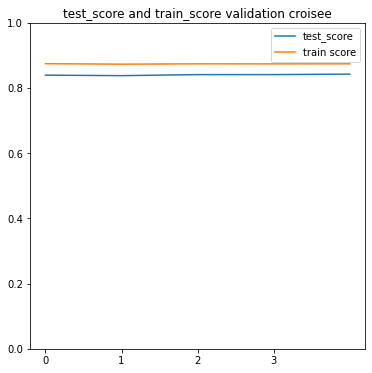

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_ylim([0,1])
plt.xticks(range(0,4))
ax.plot(cross_v['test_score'],label = "test_score")
ax.set_title('test_score and train_score validation croisee');
ax.plot(cross_v['train_score'], label="train score")
ax.legend()

## Modele SGDClassifier

In [44]:
clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                      alpha=1e-3, random_state=42,
                      max_iter=5, tol=None)),
])

clf = clf.fit(train["content"],train["lang"])

print(clf.score(train["content"],train["lang"]))
print(clf.score(valid["content"],valid["lang"]))


0.9146361841575947
0.9148409456615918


In [ ]:
print(valid.columns)
print(valid.head(2))
print()
print(ptable.columns)
print(ptable.head(2))
print()
print(lang)

# Recherche hyperparametre :

#### Nos Recherches

In [ ]:
#Todo hyperparametre (use_idf, alpha, C ...)
# Todo graphe differents hyperparametre

#### Recherche avec GridSearchCV

In [ ]:
#Todo
#determiner meilleur hyperparam avec GridSearchCV

# Analyse des resultat

In [45]:
y_true = valid["lang"]
y_pred = clf.predict(valid["content"])

[[  32  149   18    8    3    1    0   81    6]
 [   0 4117  232   59  109    8   16  608   88]
 [   0   16 7714    8    2    0    5    5    7]
 [   0    8  242 4309    1    0    5   13    4]
 [   0  107  177    6 3564    3    1  107    8]
 [   0   66   86   92   16  496  380  115   13]
 [   0   56   36    5    9    2 1800   78   11]
 [   0   57  119   15   60    0    5 9657   35]
 [   0   33   64    3    8    0    2  136 5093]]


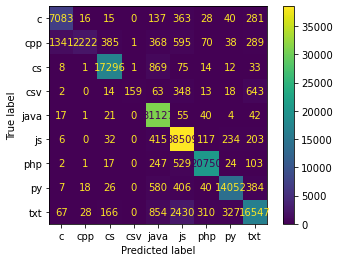

In [37]:

# Matrice de confusion
print(confusion_matrix(y_true, y_pred, labels=lang))
plot_confusion_matrix(clf, train["content"], train["lang"])
plt.show()
#Todo accuracy test

In [73]:
#R2
from sklearn.metrics import r2_score
r2 = r2_score(y_true,y_pred)
print(r2)

ValueError: could not convert string to float: 'js'

In [47]:
#MCC
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_true,y_pred)
print(mcc)

0.8990031633962652


In [74]:
#ROC
from sklearn import metrics
metrics.plot_roc_curve(clf, train["lang"], valid["lang"])  
plt.show() 

ValueError: Pipeline should be a binary classifier

In [75]:
#AUC

fpr, tpr, thresholds = metrics.roc_curve(valid["lang"], y_pred, pos_label=2)
metrics.auc(fpr, tpr)

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U4'), dtype('<U4')) -> dtype('<U4')

In [11]:
y_true =  valid["lang"]
y_pred = clf.predict(valid["content"])
target_names = lang
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         csv       0.92      0.75      0.83      1903
         txt       1.00      0.34      0.50      1299
        java       0.98      0.91      0.94      4610
          cs       1.00      0.12      0.22       319
          py       0.77      1.00      0.87      7815
         cpp       0.98      0.83      0.90      3941
           c       0.88      0.88      0.88      5213

    accuracy                           0.87     25100
   macro avg       0.93      0.69      0.73     25100
weighted avg       0.89      0.87      0.86     25100

